In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline

import numpy
import numpy.linalg
import pandas
import scipy.cluster.hierarchy
import sklearn
import sklearn.cluster
import sklearn.linear_model
import re
import matplotlib.pyplot
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [2]:
def ReduceDimensions(data,keep_variance=0.8,tolerance=1.0E-12,max_iter=1024):
    """Reduces dimensions of data"""
    residuals=data-data.mean(axis=1,keepdims=True)
    noise=(1.0-keep_variance)*residuals.var()
    convergence=1.0-tolerance
    result=None
    n=0
    while n<max_iter and residuals.var()>noise:
        component=residuals.var(axis=1,keepdims=True)
        if result is not None:
            component-=(result*(component.T.dot(result))).sum(axis=1,keepdims=True)
        component/=numpy.linalg.norm(component)
        corr=0.0
        n=0
        while n<max_iter and corr<convergence:
            projection=residuals.dot(component.T.dot(residuals).T)
            projection/=numpy.linalg.norm(projection)
            corr=projection.T.dot(component)
            component=projection
            n+=1
        if n<max_iter:
            if result is None:
                result=component
            else:
                result=numpy.hstack([result,component])
            residuals-=numpy.outer(component,component.T.dot(residuals))
    return result

In [22]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression, LassoLars

# Assuming ReduceDimensions is defined elsewhere
# from your_module import ReduceDimensions

split_name = re.compile('[.-]')

def rename_patients(name):
    components = split_name.split(name)
    return '-'.join(('TCGA', components[0], components[1]))

class BreastCancerAnalysis(object):
    """Analyses the breast cancer proteome data from Kaggle"""
    def __init__(self):
        """Loads the data tables"""
        self.protein_activity = pd.read_csv("../77_cancer_proteomes_CPTAC_itraq.csv")
        self.protein_activity.set_index(['RefSeq_accession_number','gene_symbol','gene_name'], inplace=True)
        self.protein_activity.fillna(self.protein_activity.median(), inplace=True)
        self.protein_activity.rename(columns=rename_patients, inplace=True)
        self.clinical_data = pd.read_csv("../clinical_data_breast_cancer.csv").set_index('Complete TCGA ID')
        self.principal_components = None
        self.protein_clusters = None
        self.patient_protein_activity = None
        self.clinical_prediction_models = None
        
    def fit_principal_components(self):
        """Reduces the dimensionality of the data"""
        pca = PCA(n_components=0.95)  # Adjust number of components or variance ratio as needed
        principal_components = pca.fit_transform(self.protein_activity.values.T)
        self.principal_components = pd.DataFrame(principal_components, index=self.protein_activity.columns)
        return self.principal_components
        
    def dendrogram(self):
        """Performs hierarchical clustering and plots a dendrogram to choose number of clusters to fit"""
        result = plt.gca()
        scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.ward(self.principal_components), ax=result)
        return result
        
    def cluster_proteins(self, n=2):
        """Finds clusters of proteins whose activity is related"""
        clusters = AgglomerativeClustering(n_clusters=n)
        self.protein_clusters = pd.DataFrame(clusters.fit_predict(self.principal_components),
                                             index=self.principal_components.index,
                                             columns=['Cluster'])
        return self.protein_clusters
        
    def patient_cluster_activity(self):
        """Calculates the activity of each protein cluster for each patient"""
        mean_subtracted_protein_activity = self.protein_activity.sub(self.protein_activity.mean(axis=1), axis=0)
        patient_components = mean_subtracted_protein_activity.T.dot(self.principal_components)
        kernel = self.principal_components.merge(self.protein_clusters, left_index=True, right_index=True).groupby('Cluster').mean().T
        self.patient_protein_activity = patient_components.dot(kernel)
        return self.patient_protein_activity

    def train_clinical_models(self):
        """Fits a model to predict each clinical feature from the protein activity"""
        self.clinical_prediction_models = {
            'Gender': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'Age at Initial Pathologic Diagnosis': LassoLars(copy_X=True),
            'ER Status': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'PR Status': LogisticRegression(solver='lbfgs'),
            'HER2 Final Status': LogisticRegression(solver='lbfgs'),
            'Tumor': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'Node': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'Metastasis-Coded': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'AJCC Stage': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'Vital Status': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'OS Time': LassoLars(copy_X=True),
            'PAM50 mRNA': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'SigClust Unsupervised mRNA': LassoLars(copy_X=True),
            'miRNA Clusters': LassoLars(copy_X=True),
            'methylation Clusters': LassoLars(copy_X=True),
            'RPPA Clusters': LogisticRegression(solver='lbfgs', multi_class='multinomial'),
            'Integrated Clusters (with PAM50)': LassoLars(copy_X=True),
            'Integrated Clusters (no exp)': LassoLars(copy_X=True),
            'Integrated Clusters (unsup exp)': LassoLars(copy_X=True)
        }
        combined_data = self.patient_protein_activity.merge(self.clinical_data, how='inner', left_index=True, right_index=True)
        for column, model in self.clinical_prediction_models.items():
            model.fit(combined_data[self.patient_protein_activity.columns].values, combined_data[column].values)
        return pd.Series({column: model.score(combined_data[self.patient_protein_activity.columns].values, combined_data[column].values)
                          for column, model in self.clinical_prediction_models.items()}).plot.barh()
    
    def visualize(self, model):
        """Plots a chart of the chosen model"""
        data = None
        coefficients = self.clinical_prediction_models[model]
        if coefficients.__class__.__name__ == 'LogisticRegression':
            data = pd.DataFrame(coefficients.coef_.T,
                                columns=coefficients.classes_[:coefficients.coef_.shape[0]],
                                index=self.patient_protein_activity.columns)
        else:
            data = pd.Series(coefficients.coef_, index=self.patient_protein_activity.columns)
        return data.plot.bar(figsize=(6, 4))
    
    def save_cluster_results(self, filename='cluster.csv'):
        """Saves the clustering results to a CSV file with specific column names"""
        # Make sure the principal components and clusters are calculated
        if self.principal_components is None or self.protein_clusters is None:
            raise ValueError("Principal components or protein clusters are not calculated. Please run fit_principal_components and cluster_proteins methods first.")
        
        # Create a DataFrame with feature names and clusters
        cluster_results = self.principal_components.copy()
        cluster_results.columns = [f"Feature_{i+1}" for i in range(cluster_results.shape[1])]
        cluster_results['Cluster'] = self.protein_clusters['Cluster']
        
        # Save the DataFrame to CSV
        cluster_results.to_csv(filename, index=False)
        print(f"Cluster results saved to {filename}")

# Example usage
# bca = BreastCancerAnalysis()
# bca.fit_principal_components()
# bca.cluster_proteins(n=4)
# bca.save_cluster_results()


## Clustering protein activity
Previous work on this dataset has involved clustering patients according to their protein activity. For this analysis, I decided to cluster proteins according to their activity in different patients, and then use the activity of the different clusters to predict clinical features. Biologically speaking, it is assumed that proteins whose activity clusters together comprise interacting systems.
First, the dimensionality of dataset is reduced, and then a hierarchical cluster is fitted to the principal components, which is visualised as a dendrogram to select the appropriate number of components.

<Axes: >

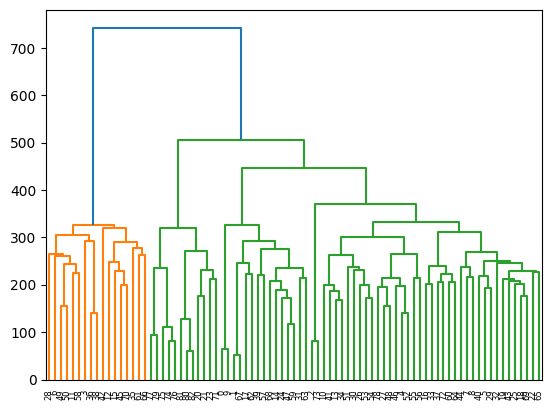

In [25]:
models=BreastCancerAnalysis()
models.fit_principal_components()
models.dendrogram()

From this it appears that 8 components are appropriate. Therefore, hierarchical clustering is rerun and the proteins assigned to 8 clusters

In [7]:
models.cluster_proteins(8)
models.save_cluster_results()

,,,cluster
RefSeq_accession_number,gene_symbol,gene_name,
NP_958782,PLEC,plectin isoform 1,6
NP_958785,NaN,plectin isoform 1g,6
NP_958786,PLEC,plectin isoform 1a,6
NP_000436,NaN,plectin isoform 1c,6
NP_958781,NaN,plectin isoform 1e,6
...,...,...,...
NP_001191293,NaN,protein FAM24B precursor,7
NP_775791,NaN,putative uncharacterized protein C9orf62,1
NP_004065,COX8A,"cytochrome c oxidase subunit 8A, mitochondrial",1


## Protein activity per patient
Projecting the patient's protein activity onto the eigenvectors derived above, and then projecting those vectors into the space of the means of the clusters, the patients' activity for each cluster is calculated.


In [8]:
models.patient_cluster_activity()

cluster,0,1,2,3,4,5,6,7
TCGA-AO-A12D,0.917231,0.120564,-0.131219,-1.217355,1.694023,0.457643,0.660013,0.958409
TCGA-C8-A131,0.673408,0.104801,3.772445,-0.624512,0.805507,0.374236,0.601963,0.648450
TCGA-AO-A12B,-0.161929,-0.002945,-0.726941,-2.114828,-0.766855,-1.125559,-1.682631,-0.531601
TCGA-BH-A18Q,-2.379686,-0.258032,-1.217904,-0.507265,-0.576811,1.443751,-0.519773,-2.977502
TCGA-C8-A130,0.519268,0.145321,-0.787509,-0.602994,-0.273223,-0.437974,0.128785,0.656380
...,...,...,...,...,...,...,...,...
TCGA-BH-A0C7,0.286719,-0.127704,-0.006070,0.071831,-0.828869,-0.473030,0.190112,0.399791
TCGA-A2-A0SX,0.701843,-0.046272,2.132516,2.085149,-0.588166,1.413544,0.403965,0.845956
TCGA-263d3f-I,0.209740,0.234159,1.773149,3.657372,-0.349064,-0.176786,0.689142,-0.292076
TCGA-blcdb9-I,-0.074353,-0.052396,0.772905,1.145733,-0.285471,-0.535294,-0.407381,-0.646755


## Modelling clinical features

A set of generalized linear predictors (LassoLars for numerical variables, Logistic Regression for categorical variables) is then fit to the clinical data, using the protein cluster activity as the independent variables

<Axes: >

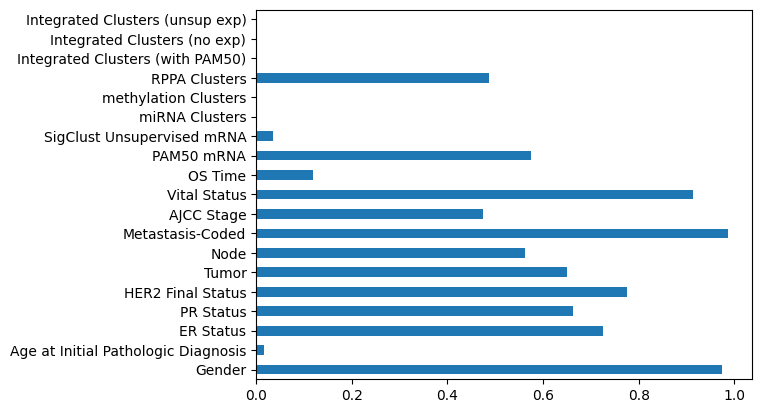

In [9]:
models.train_clinical_models()

Strong predictors can be found for several clinical factors. These are discussed below.

## Gender

<Axes: xlabel='cluster'>

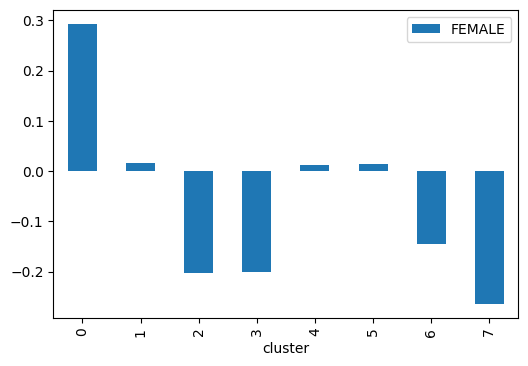

In [10]:
models.visualize('Gender')

Activity of cluster 0 is greater in female patents, while activity in clusters 2, 3, 6 and 7 is greater in male patients.

## ER Status

<Axes: xlabel='cluster'>

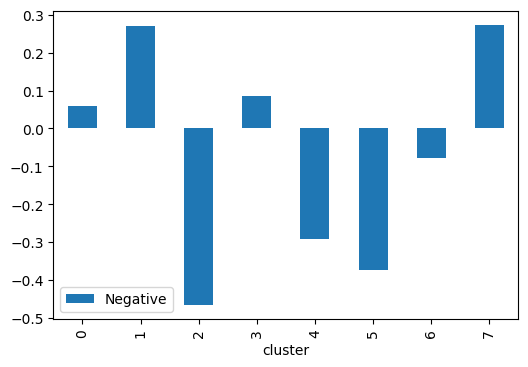

In [11]:
models.visualize('ER Status')

Activity in clusters 2, 4 and 5 makes positive ER status more likely, while it is less likely in patients with activity in clusters 1 and 7.

## PR Status

<Axes: xlabel='cluster'>

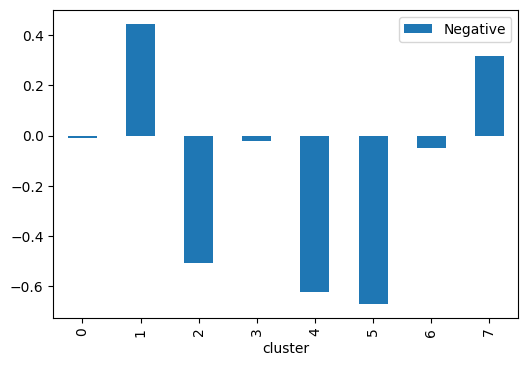

In [12]:
models.visualize('PR Status')

The same clusters are correlated in the same way with ER status.

## HER2 Final Status

<Axes: xlabel='cluster'>

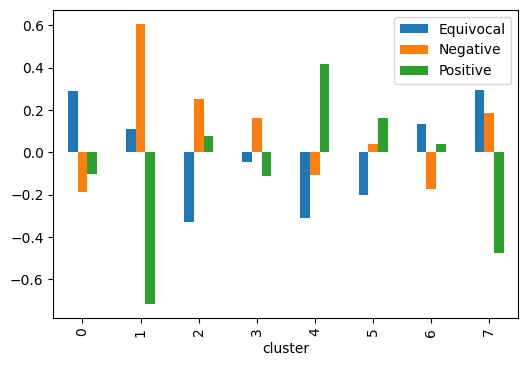

In [13]:
models.visualize('HER2 Final Status')

HER2 Final status is much more likely to be negative in patients with activity in clusters 1 and 7, and more likely to be positive in patients with activity in cluster 4.

## Tumor

<Axes: xlabel='cluster'>

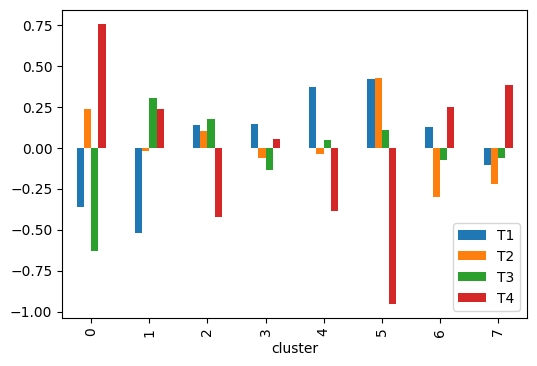

In [14]:
models.visualize('Tumor')

* T1 tumors are most likely in patients with activity in clusters 4 and 5, and least likely in patients with activity in clusters 0 and 1.
* T2 tumors are most likely in patients with activity in cluster 5.
* T3 tumors are significantly less likely in patients with activity in cluster 0.
* T4 tumors are most likely in patients with activity on cluster 0 and least likely in patients with activity in cluster 5.

## Node

<Axes: xlabel='cluster'>

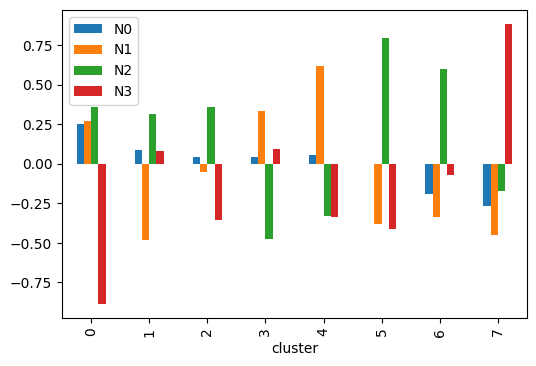

In [15]:
models.visualize('Node')

* N0 Node is slighlty more likely in patients with activity in cluster 0, and slightly less likely in patients with activity in clusters 6 and 7.
* N1 Node is most likely in patients with activity in cluster 4 and least likely in patients with activity in cluster 1
* N2 Node is most likely in patients with activity in clusters 5 and 6 and least likely patients with activity in cluster 3.
* N3 Node is most likely in patients with activity in cluster 7 and least likely in patients with activity in cluster 0.

## Metastasis

<Axes: xlabel='cluster'>

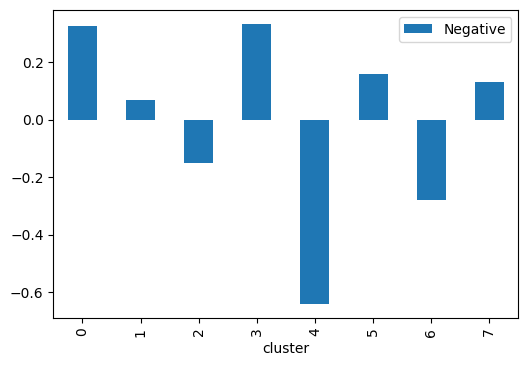

In [16]:
models.visualize('Metastasis-Coded')

Metastasis is least likely in patients with activity in cluster 4. This result should be treated with caution, as few patients in this sample exhibit metastasis.

<Axes: xlabel='cluster'>

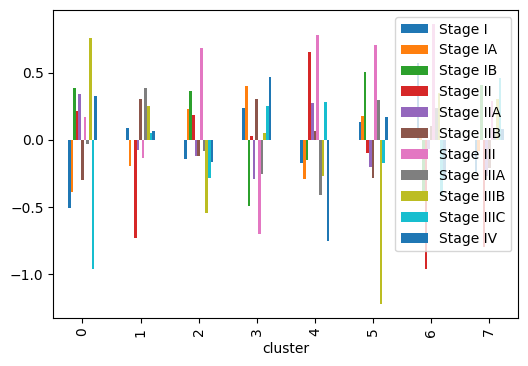

In [17]:
models.visualize('AJCC Stage')

## Vital Status

<Axes: xlabel='cluster'>

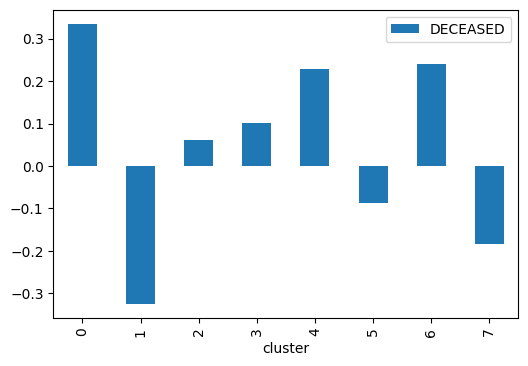

In [18]:
models.visualize('Vital Status')

Patients with activity in cluster 0 are most likely to die. Patients with activity in cluster 1 are least likely to die.

<Axes: xlabel='cluster'>

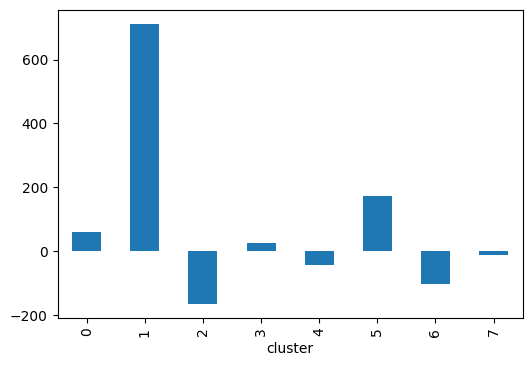

In [19]:
models.visualize('OS Time')

Activity in cluster 1 predicts longer OS times

## PAM50 mRNA

<Axes: xlabel='cluster'>

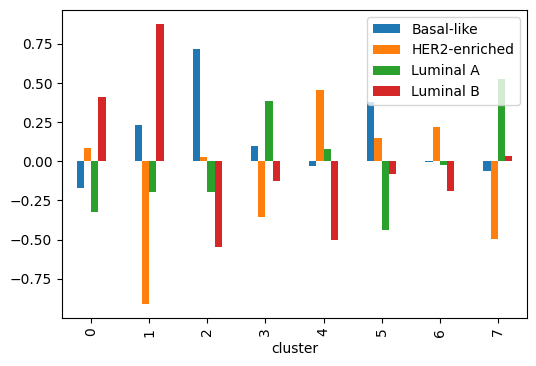

In [20]:
models.visualize('PAM50 mRNA')

Luminal B PAM50 RNA is most likely in patients with activity in cluster 1, and less likely in patients with activity in clusters 2 and 4. HER2-enriched PAM50 RNA is lest likely in patients with activity in cluster 1. Basal-like PAM50 RNA is most likely in patients with activity in cluster 2.

## RPPA Clusters

<Axes: xlabel='cluster'>

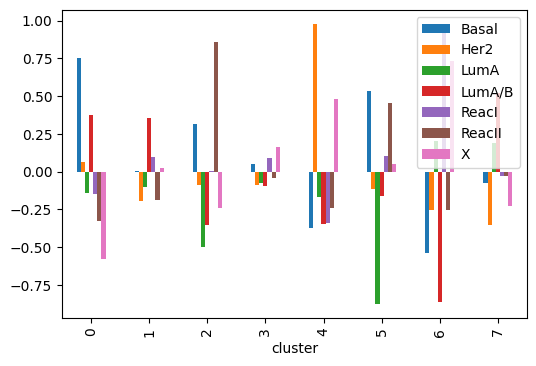

In [21]:
models.visualize('RPPA Clusters')

HER2 RPPA Clusters are most likely in patients with activity in cluster 4. Lum A RPPA clusters are least likely in patients with activity in cluster 5. Lum A/B clusters are least likely in patients with activity in cluster 6.

